# Solution - Multidimensional Linear Regression

<img src="https://assets.amuniversal.com/7f343ac0870a01332a13005056a9545d" width=400px>

---
## Goals

After completing this notebook, you will be able to:
1. Read in a fixed width data set and assign column names
2. Clean missing data from a data set
3. Construct a set of linear regression model usings `scikit-learn`
4. Evaluate the quality of fit for a set of models using adjusted $R^2$ and by comparing true and predicted values
5. Explain why that model is the best fit for this data

## 0. Our imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

%matplotlib inline

## 1. Working with example data 

We are going to work with some data generated by U.N.E.S.C.O. (United Nations Education, Scientific, and Cultural Organization) and data they collected relating to poverty and inequality in the world. There are two files you need to do the work:

- `poverty.dat` which is the data file itself
- `poverty.txt` which describes the data columns as **fixed width column** data. That is, this file describes the columns of the data for each category. For example, the data in columns 1-6 of `poverty.dat` contain the "live birth rates per 1,000 population".

[https://raw.githubusercontent.com/dannycab/MSU_REU_ML_course/main/notebooks/day-2/poverty.dat](https://raw.githubusercontent.com/dannycab/MSU_REU_ML_course/main/notebooks/day-2/poverty.dat)

[https://raw.githubusercontent.com/dannycab/MSU_REU_ML_course/main/notebooks/day-2/poverty.txt](https://raw.githubusercontent.com/dannycab/MSU_REU_ML_course/main/notebooks/day-2/poverty.txt)

Conveniently there is a fixed width column pandas data reader called `read_fwf` ([Documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_fwf.html)). You will need to specific column names also. No column headers appear in this data file, so look at the `poverty.txt` file and give them short but useful names.

<font size=8 color="#009600">&#9998;</font> Do This - Read in the data into a DataFrame and print the `head()`.

In [2]:
## your code here

In [3]:
### ANSWER ###

poverty_df = pd.read_fwf('https://raw.githubusercontent.com/dannycab/MSU_REU_ML_course/main/notebooks/day-2/poverty.dat', 
                         names = ['birth rate',
                                    'death rate',
                                    'infant mortality',
                                    'male LE',
                                    'female LE',
                                    'GNP',
                                    'country group',
                                    'country'])
poverty_df.head()

,birth rate,death rate,infant mortality,male LE,female LE,GNP,country group,country
0,24.7,5.7,30.8,69.6,75.5,600,1,Albania
1,12.5,11.9,14.4,68.3,74.7,2250,1,Bulgaria
2,13.4,11.7,11.3,71.8,77.7,2980,1,Czechoslovakia
3,12.0,12.4,7.6,69.8,75.9,*,1,Former_E._Germany
4,11.6,13.4,14.8,65.4,73.8,2780,1,Hungary


### 1.1 Type of the data

Now look at the `.dtypes` of your DataFrame and describe to me anything unusual. Can you explain why? Please write below. Don't skimp and look ahead, think about it and answer! We'll all wait <font size=6 color="#009600">&#9202;</font>

<font size=8 color="#009600">&#9998;</font> Answer here

### 1.2 Handling missing data - Imputation

Let's face it, sometimes data is bad. Values are not recorded, or are mis-recorded, or are so far out of expectation that you expect there is something wrong. On the other hand, just **changing** the data seems like cheating. We have to work with what we have, and if we have to make changes it would be good to do that programmatically so that it is recorded for others to see. 

The process of <a href="https://en.wikipedia.org/wiki/Imputation_(statistics)"> imputation </a> is the statistical replacement of missing/bad data with substitute values. We have that problem here. In the **GNP** column some of the values are set to " \* " indicating missing data. When pandas read in the column the only type that makes sense for both characters and numbers is a string. Therefore it set the type to `object` instead of the expected `int64` or `float64`.

#### Using numpy.nan

For better or worse, pandas assumes that "bad values" are marked in the data as numpy **NaN**. NaN is short for "Not a Number". If they are so marked we have access to some of the imputation methods, replacing NaN with various values (mean, median, specific value, etc.). 

There are two ways to do this:
1. you can do a `.replace` on the column using a dictionary of {value to replace : new value, ...} pairs. Remember to save the result. This leaves you with changing the column type using `.astype` but you will have convert to a float, perhaps `"float64"` would be good. You cannot convert a `np.nan` to an integer but you can to a float.
2. you can convert the everything that can be converted to a number using `.to_numeric`. Conveniently if it can't do the conversion on a particular value it is set to a `np.nan`

<font size=8 color="#009600">&#9998;</font> Do This - Convert the missing entries in the GNP column to `np.nan` and show the head of your modified DataFrame. Also print the `dtypes` to show that the column has change type.

In [4]:
## your code here

In [5]:
### ANSWER ###

poverty_df['GNP'].replace(to_replace='*', value=np.nan, inplace=True)
poverty_df['GNP'] = poverty_df['GNP'].astype('float64')

poverty_df.dtypes

birth rate          float64
death rate          float64
infant mortality    float64
male LE             float64
female LE           float64
GNP                 float64
country group         int64
country              object
dtype: object

#### Changing numpy.nan

Now that "bad values" are marked as `numpy.nan`, we can use the DataFrame method `fillna` to change those values. For example:

In [6]:
## Uncomment to run

poverty_df["GNP"].fillna(0)

0      600.0
1     2250.0
2     2980.0
3        0.0
4     2780.0
       ...  
92     220.0
93     110.0
94     220.0
95     420.0
96     640.0
Name: GNP, Length: 97, dtype: float64

returns a new DataFrame where all the `np.nan` in the GNP column are replaced with 0. You can do other things are well, for example:

In [7]:
## Uncomment to run
poverty_df["GNP"].fillna(poverty_df["GNP"].mean() )
poverty_df.fillna({"GNP": poverty_df["GNP"].mean() })

,birth rate,death rate,infant mortality,male LE,female LE,GNP,country group,country
0,24.7,5.7,30.8,69.6,75.5,600.000000,1,Albania
1,12.5,11.9,14.4,68.3,74.7,2250.000000,1,Bulgaria
2,13.4,11.7,11.3,71.8,77.7,2980.000000,1,Czechoslovakia
3,12.0,12.4,7.6,69.8,75.9,5741.252747,1,Former_E._Germany
4,11.6,13.4,14.8,65.4,73.8,2780.000000,1,Hungary
...,...,...,...,...,...,...,...,...
92,52.2,15.6,103.0,49.9,52.7,220.000000,6,Uganda
93,50.5,14.0,106.0,51.3,54.7,110.000000,6,Tanzania
94,45.6,14.2,83.0,50.3,53.7,220.000000,6,Zaire
95,51.1,13.7,80.0,50.4,52.5,420.000000,6,Zambia


The first version changes any `np.nan` in the `GNP` column to be the mean of the column. The second takes a dictionary where the the key of the dictionary is the column to change and the value is what to replace the `np.nan` with. Note you could replace with other values like: median, min, max, or some other fixed value.

Remember that all of these examples return either a new Series (when working with just a column) or a DataFrame (if working with the entire element). Nothing is changed in the original unless you assign the result or use `inplace=True` in the call.

Finally, if you decide that the right thing to do is **remove** any row with a `np.nan` value, we can use the `.dropna` method of DataFrames as shown below:

In [8]:
## Uncomment to run
len(poverty_df)
poverty_df_dropped = poverty_df.dropna()
print(len(poverty_df), len(poverty_df_dropped))

97 91


#### What do you think

In the cell below, discuss with your group what you think is the best thing to do with the "bad values" in the DataFrame given the discussion above. Write your result below.

<font size=8 color="#009600">&#9998;</font> Answer here

## 2. Multiple Regression

In the past, we have limited ourselves to either a single feature or, in the pre-class, doing polynomial regression with other features we created. However, we can just as easily use all, or some combination of all, the features available to make a OLS model. The question is, is it a good idea to just use all the possible features available to make a model?

Please discuss that idea with your group and record your answer below.

<font size=8 color="#009600">&#9998;</font> Answer here

### 2.1 Infant Mortality model

Using the U.N.E.S.C.O. data, we can make a model of "Infant Mortality" as the dependent variable against all the other available features. As a hint, an easy way to do this is the make the model with  "Infant Mortality" as the prediction (the dependent variable) and then the entire DataFrame where "Infant Mortality is dropped as the data (the independent variables). **You should also drop the "Country" column as unique strings don't play well in basic linear models.**

<font size=8 color="#009600">&#9998;</font> Do This - Make an linear model (did you split your data?) that predicts "Infant Mortality" using the other variables (dropping the "Country" column) and print the `.r2_score` of that process. 

In [9]:
# your code here

In [10]:
### ANSWER ###

X = poverty_df_dropped.drop(columns = ['infant mortality', 'country'])
y = poverty_df_dropped['infant mortality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear = LinearRegression()

linear.fit(X_train,y_train)

y_pred = linear.predict(X_test)

r2=metrics.r2_score(y_test, y_pred)
print('r2: ', round(r2,4))

r2:  0.9401


### 2.2 Visualizing your fit

We can check how well we are justified in using this model, by comparing the actual and predicted values. Plot the predicted values against the real values. In a perfect model, they would form a line with a slope of 1.


<font size=8 color="#009600">&#9998;</font> Do This - Make the plots mentioned above. How well does your model fit your data? What can you conclude from this graph?

In [11]:
### your code here

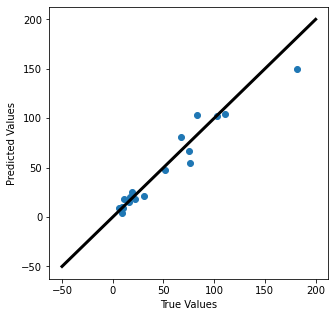

In [12]:
### ANSWER ###

plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([-50,200],[-50,200], color='k', lw=3)

# res = y_test-y_pred

# plt.figure(figsize=(5,5))
# plt.scatter(X_test['male LE'], res)
# plt.xlabel('x')
# plt.ylabel('Residuals')

### 2.3 A "reduced" model using only the "significant" features

Modeling data is as much a craft as it is a science. We often seek the simplest models that explain or data well because they are typically more interpretable, easier to explain, and provide the information on the main influences of the system we are studying. There are reasons we might want a more complex model to capture the details and the nuance of the system. But for the U.N.E.S.C.O. data that we have, we are likely able to capture most of the system using a smaller number of features. 

<font size=8 color="#009600">&#9998;</font> Do This - use `pandas` built=in correlation function (`.corr()`) to find the top 3 variables that correlate strongly with "Infant Mortality"

In [13]:
# your code here

In [14]:
### ANSWER ###

poverty_df_dropped.corr()

,birth rate,death rate,infant mortality,male LE,female LE,GNP,country group
birth rate,1.000000,0.505626,0.856537,-0.866200,-0.894440,-0.629059,0.710212
death rate,0.505626,1.000000,0.677741,-0.754032,-0.714751,-0.302754,0.344168
infant mortality,0.856537,0.677741,1.000000,-0.935238,-0.954225,-0.601647,0.631913
male LE,-0.866200,-0.754032,-0.935238,1.000000,0.981957,0.642963,-0.642059
female LE,-0.894440,-0.714751,-0.954225,0.981957,1.000000,0.650040,-0.699097
GNP,-0.629059,-0.302754,-0.601647,0.642963,0.650040,1.000000,-0.283399
country group,0.710212,0.344168,0.631913,-0.642059,-0.699097,-0.283399,1.000000


<font size=8 color="#009600">&#9998;</font> Do This - Redo the model with only the top three features you found above vs "Infant Mortality". Print the `.r2_score`, how does it compare to the full model?

In [15]:
### your code here

In [16]:
### ANSWER ###

X1 = poverty_df_dropped.drop(columns = ['infant mortality', 'country', 'country group', 'GNP', 'death rate'])
y1 = poverty_df_dropped['infant mortality']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)

linear = LinearRegression()

linear.fit(X_train1,y_train1)

y_pred1 = linear.predict(X_test1)

r2=metrics.r2_score(y_test1, y_pred1)
print('r2: ', round(r2,4))

r2:  0.9181


<font size=8 color="#009600">&#9998;</font> Do This -  Make the same comparison plot mentioned above. How well does your model fit your data? What can you conclude from this graph? Can you compare it to the previous fit?

In [17]:
### your code here

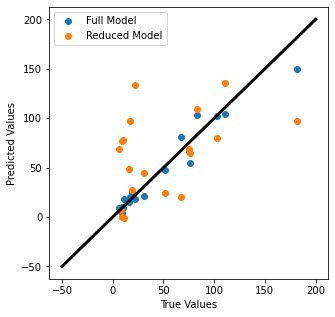

In [18]:
### ANSWER ###

plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred)
plt.scatter(y_test,y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend(['Full Model', 'Reduced Model'])

plt.plot([-50,200],[-50,200], color='k', lw=3)

# res = y_test-y_pred

# plt.figure(figsize=(5,5))
# plt.scatter(X_test['male LE'], res)
# plt.xlabel('x')
# plt.ylabel('Residuals')

Review this model and the one you constructed earlier in the notebook. Report how the Adjusted R-squared value changed from using only the top three vs using all the available features. How well does this reduced model appear to fit your data?

<font size=8 color="#009600">&#9998;</font> Answer here